# Phase Change Indicator

In [1]:
import pandas as pd
import numpy as np

# Finance Library import
from Library import FinanceLibrary as fl

In [2]:
df = pd.read_csv("..\\Data\\KOSPI_Daily_1980data.csv", encoding="utf-8")
df.index = pd.to_datetime(df["Date"])
df_close = df["Close"]
# 데이타 기간
#df_close = df_close["2015":]

df_close = df_close/df_close[0]  #re-scale
KOSPI = pd.DataFrame(df_close, index=df_close.index)

In [3]:
Period = 20  # 기간
P = Period - 1  # 기간 index
# 모멘텀
KOSPI["Momentum"] = KOSPI - KOSPI.shift(P)

In [4]:
# PCI 구하기
PCI = [0] * P  # PCI 저장할 리스트
for ind in range(P,len(KOSPI)):
    sumUpDi =  0.0
    sumDownDi = 0.0
    Gradient = []
    Deviation = []
    for ind2 in range(Period):
        # ex) 5일 첫 Close + 5일 모멘텀 * 0/4, 1/4, 2/4, 3/4, 4/4
        val2 = KOSPI["Close"].iloc[ind-P] + (KOSPI["Momentum"].iloc[ind]*(ind2)/P)
        Gradient.append(np.round(val2,4))
    for ind3 in range(Period):
        val3 = KOSPI["Close"].iloc[ind-P+ind3] - Gradient[ind3]
        if KOSPI["Close"].iloc[ind-P+ind3] > Gradient[ind3]:
            sumUpDi += abs(val3)
        elif KOSPI["Close"].iloc[ind-P+ind3] < Gradient[ind3]:
            sumDownDi += abs(val3)
        else:
            None
    #ZeroDivisionError 방지코자 if문 사용함
    if sumUpDi != 0:
        a = sumUpDi / (sumUpDi+sumDownDi) * 100
        PCI.append(np.round(a,2))
    else:
        PCI.append(0)
    #print ("sumDownDi {} sumUpDi {}".format(sumDownDi, sumUpDi))
# df에 값 기록하기
KOSPI["PCI"] = PCI

In [5]:
# Momentum > 0 이고, PCI < 20 일때 매수 
# Momentum < 0 이고, PCI > 80 일때 매도 
entry = []
for i in range(len(KOSPI)):
    if KOSPI["Momentum"][i] > 0 and KOSPI["PCI"][i] < 20:
        #entry.append("Buy")
        entry.append(1)
    elif KOSPI["Momentum"][i] < 0 and KOSPI["PCI"][i] > 80:
        #entry.append("Sell")
        entry.append(0)
    else:
        #entry.append("Hold")
        entry.append(np.NaN)
KOSPI["Entry"] = entry
KOSPI["Entry"][0] = 0  # 첫번째 값을 "0"으로 세팅하여 현재 매도 상태임을 명시
KOSPI["Entry"] = KOSPI["Entry"].fillna(method="ffill")  # NaN은 횡보임으로 앞의 값으로 채움

In [6]:
KOSPI["YesterdayReturn"] = fl.YesterdayReturn(KOSPI["Close"])
KOSPI["YesterdayReturn"].iloc[0] = 1
# 매무 중요 진입 시그널은 어제것을 사용한다. 왜? 수익이 "어제 진입해서 오늘 확증"되는 수익률 임으로
KOSPI["TestingReturn"] = KOSPI["YesterdayReturn"] * KOSPI["Entry"].shift(1)

# cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.

In [7]:
#cumprod 할때 "0"이 있으면 무조건 수익률이 0으로 나옴으로 "0"을 제거하는 코드 필요함.
KOSPI["TestingReturn"] = KOSPI["TestingReturn"].apply(lambda x: np.NaN if x == 0 else x)
KOSPI["TestingReturn"].iloc[0] = 1
KOSPI["BackTesting"] = KOSPI["TestingReturn"].cumprod()

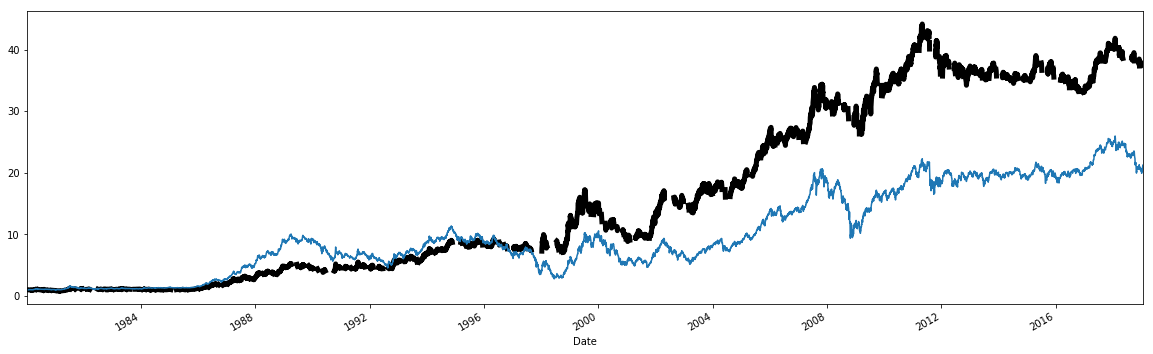

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

KOSPI["TestingReturn"].cumprod().plot(figsize=(20,6),color="Black",linewidth=5)
KOSPI["YesterdayReturn"].cumprod().plot(figsize=(20,6))
plt.show()

In [9]:
fl.Portfolio(KOSPI["BackTesting"])

Initial Balnce     1.000000
Final Balance     37.823621
CAGR               9.507600
Std               13.879006
Max.Drawdown     -48.713200
Sharpe Ratio       0.055945
Name: Portfolio, dtype: float64

In [10]:
fl.Portfolio(KOSPI["Close"])

Initial Balnce     1.000000
Final Balance     21.242800
CAGR               7.939500
Std                6.774715
Max.Drawdown     -75.411600
Sharpe Ratio       0.027213
Name: Portfolio, dtype: float64